In [16]:
import sys
sys.path.append('/home/emastr/github/vahid_project/')
sys.path.append('/home/emastr/github/vahid_project/util/')
sys.path.append('/home/emastr/github/vahid_project/src/')

from alignment_vmap import *
import numpy as np
import jax.numpy as jnp
from numpy.fft import fft, ifft
import jax
import time
from jax import vmap, grad, jit, random, lax
from util.logger import EventTracker
import matplotlib.pyplot as plt

In [17]:
logger = EventTracker()
d =81
N=int(1e4)
noise= 200. ** 0.5#5 ** 0.5#1.



#d = 5
#N = int(4e3)
#noise = 1/2.**0.5#1.#1.#1.

## GENERATE SIGNAL
t = np.linspace(0, 2*np.pi, d+1)[:-1]
#x = (t < np.pi).astype(float)
x = np.random.randn(d)
#x = np.exp(4 * jnp.sin(t))
#x = x / np.linalg.norm(x) * np.sqrt(d)

shift = np.random.randint(0, d, N)
y = np.vstack([jnp.roll(x, s) for s in shift])
w = np.random.randn(*y.shape) * noise
y = y + w
w_roll = np.vstack([jnp.roll(w_i, -s) for w_i, s in zip(w, shift)])

## FOURIER TRANSFORM
xfft = fft(x)
yfft = fft(y, axis=1)

# Moments
acf_fft = jnp.clip(jnp.mean(np.abs(yfft)**2, axis=0) - noise**2 * d, 0, None)
#acf_fft = xfft * xfft.conj()
mean = jnp.mean(yfft[:, 0])

x0 = y[0, :].copy()

print(f'SNR: {np.linalg.norm(x) ** 2 / (noise ** 2 * d)}')

SNR: 0.0046578775765071


In [18]:
x0multiple = jnp.tile(x0, (3, 1))
print(x0multiple.shape)

(3, 81)


In [19]:

iters = []
losses = []
xs = []

print('\n ### EM-Method ###')
iter = []
loss = []
def cb(xfft, res, it):
    xfft = project_moments(xfft, acf_fft, mean)
    loss.append(loss_fft(xfft, yfft))
    iter.append(xfft.copy())
    print(f"step {it}. res: {res}, loss: {loss[-1]}", end="\r")

t = time.time()
xi = em_method(fft(x0), y, noise, tol=1e-10, batch_niter=100, full_niter=500, callback=cb)

xem = xi
print(f'Time: {time.time() - t}')



iters.append(iter)
losses.append(loss)
xs.append(xi)


print('\n### STOCHASTIC GRADIENT DESCENT ###')
iter = []
loss = []
def cb(xfft, res, it):
    loss.append(loss_fft(xfft, yfft))
    iter.append(xfft.copy())
    print(f"step {it}. res: {res}, loss: {loss[-1]}", end="\r")

#xi = ifft(stochastic_fix_point_iter(fft(x0), yfft, acf_fft, mean, tol=1e-5, batch_size=int(1e3), maxiter=2000, callback=cb)).real

#iters.append(iter)
#losses.append(loss)
#xs.append(xi)

print('\n### COMPETING GRADIENT DESCENT ###')
iter = []
loss = []
x0multiple=jnp.tile(x0, (10, 1))
#xi = ifft(competing_fix_point_iter(fft(x0multiple, axis=1), yfft, acf_fft, mean, decay=0.5, tol=1e-5, num_inits=2, maxiter=6000, callback=cb)).real


#iters.append(iter)
#losses.append(loss)
#xs.append(xi)


print('\n ### FIX POINT ITERATIONS ###')
iter = []
loss = []
def cb(xfft, res, it):
    loss.append(loss_fft(xfft, yfft))
    iter.append(xfft.copy())
    print(f"step {it}. res: {res}, loss: {loss[-1]}", end="\r")

t = time.time()
xi = ifft(fix_point_iter(fft(xi), yfft, acf_fft, mean, alpha=1.0, tol=1e-10, maxiter=3000, callback=cb)).real
print(f'Time: {time.time() - t}')

iters.append(iter)
losses.append(loss)
xs.append(xi)







 ### EM-Method ###
81 10000 (81,)
Time for batch iterations: 0.8634188175201416

Time: 29.72501564025879s: 15657.0986328125

### STOCHASTIC GRADIENT DESCENT ###

### COMPETING GRADIENT DESCENT ###

 ### FIX POINT ITERATIONS ###
Time: 5.273340702056885s: 15652.9755859375: 15652.97558593755


EM: 1.7463598597058936
FP: 1.3150769419111574


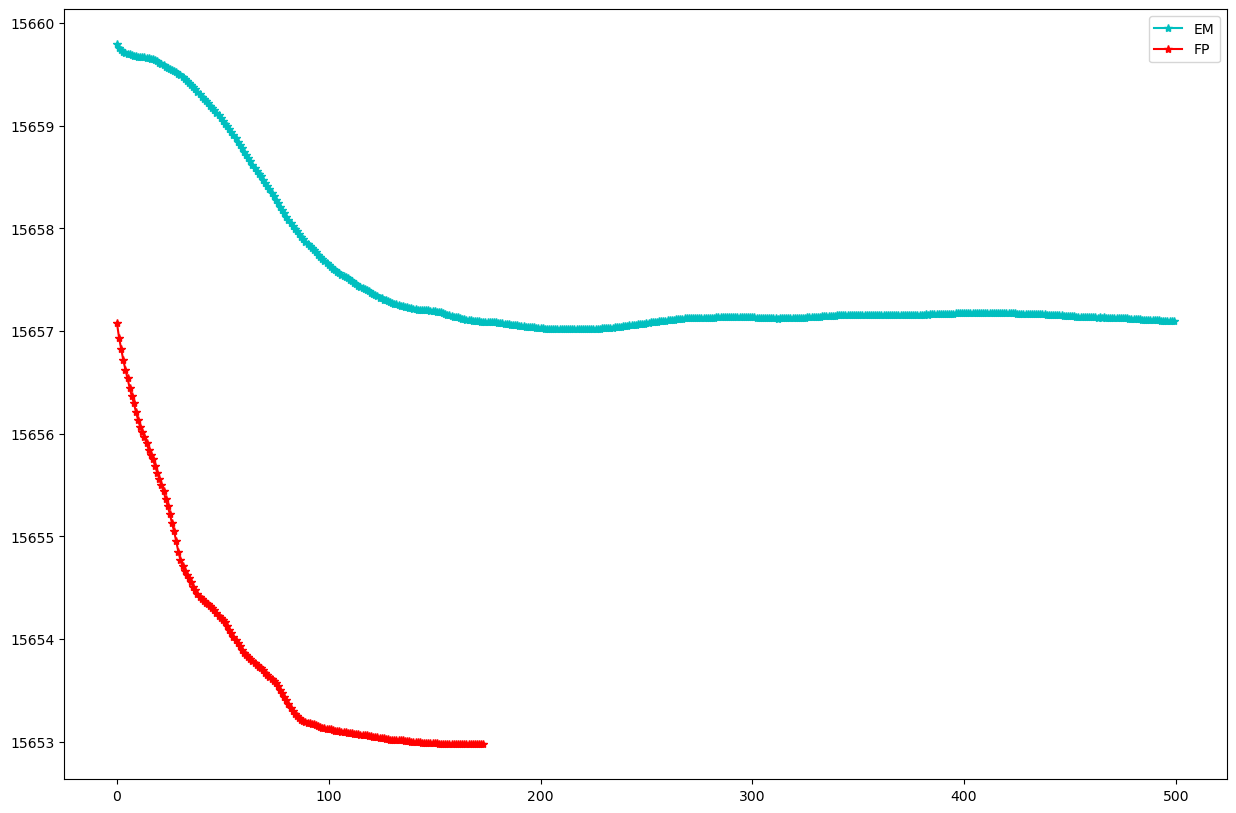

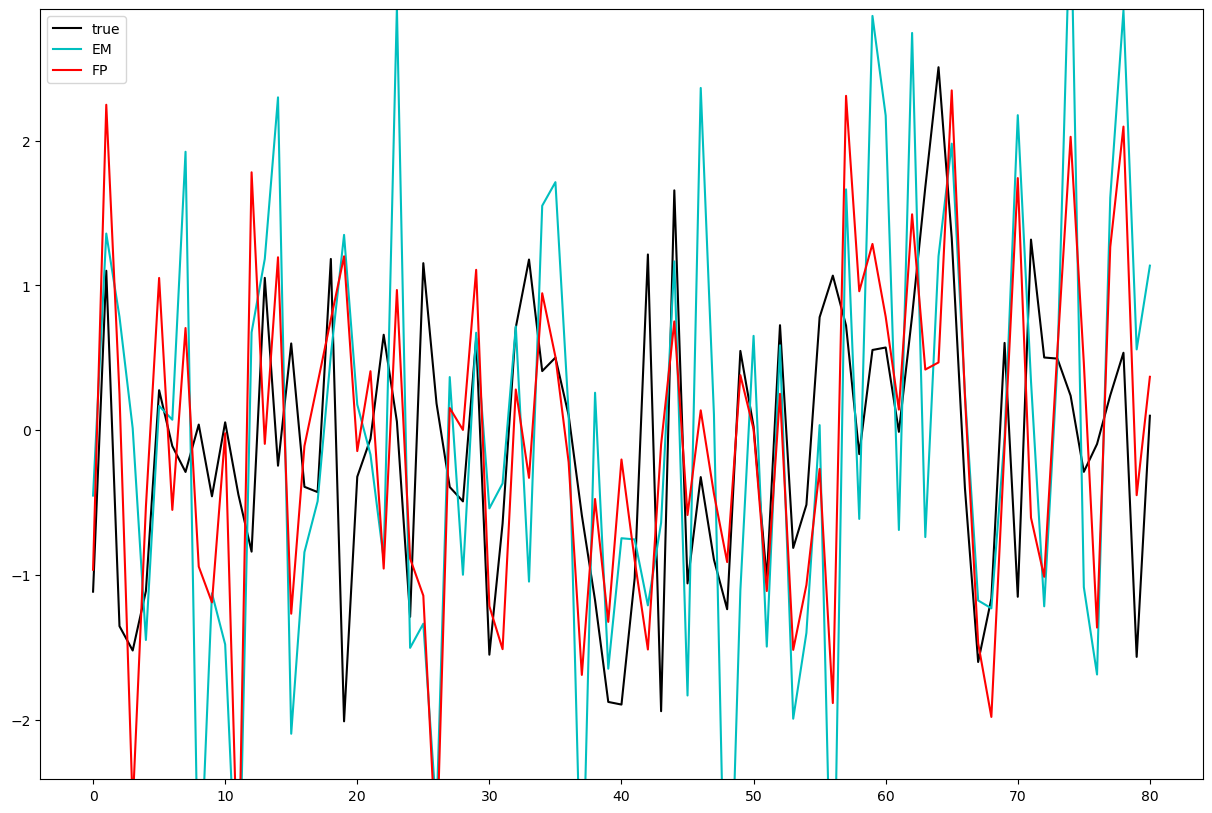

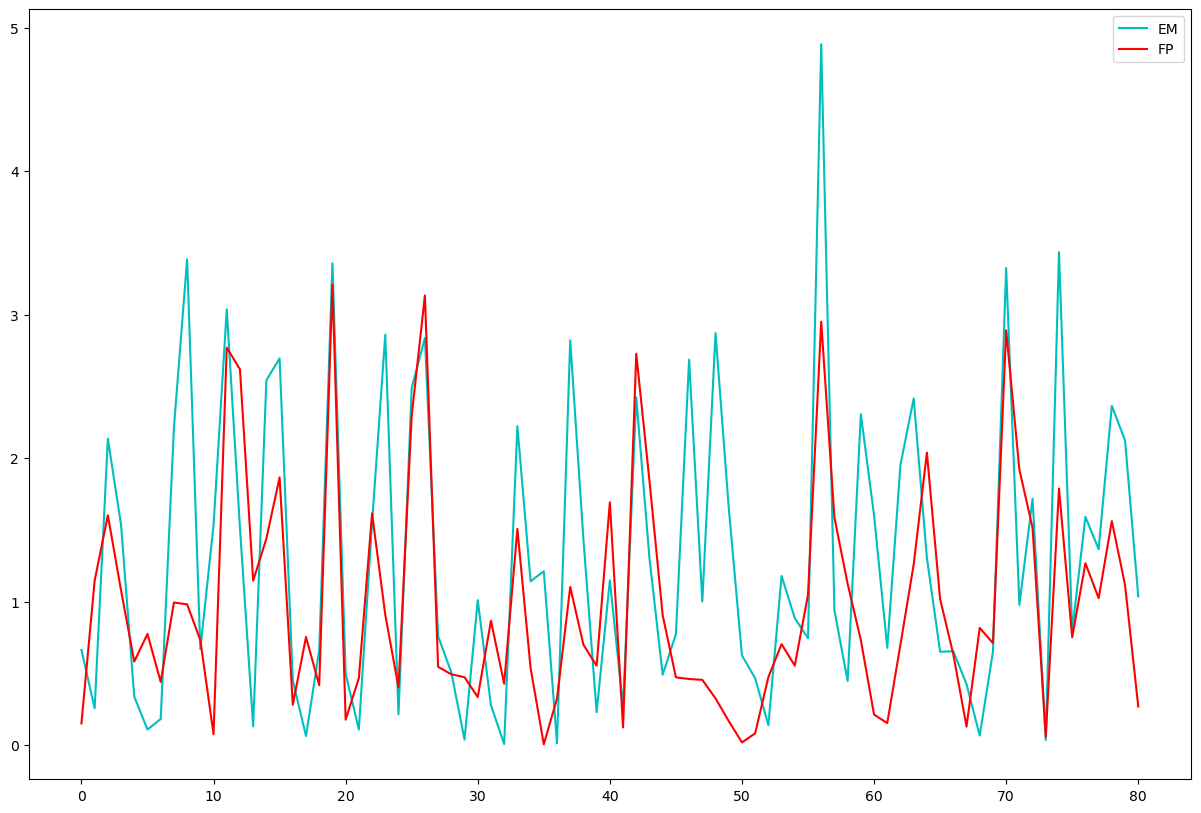

In [20]:
#losses = [losses_fp, losses_pg, losses_pn]
names = ['EM', 'FP']#['EM', 'SFP', 'CFP', 'FP']
linestyles = ['c-', 'r-']#, 'b--', 'g:']

plt.figure(1, figsize=(15,10))
plt.figure(2, figsize=(15,10))
plt.plot(x, 'k', label='true')
plt.figure(3, figsize=(15,10))

for xi, li, ni, ls in zip(xs, losses, names, linestyles):
    x_al = align(fft(x), fft(xi)[None, :], xi[None, :])[0].real
    
    print(f"{ni}: {np.linalg.norm(x - x_al)/np.linalg.norm(x)}")
    
    plt.figure(1)
    plt.plot(li, ls + '*', label=ni)    

    plt.figure(2)
    plt.plot(x_al, ls, label=ni)
    
    plt.figure(3)
    plt.plot(np.abs(x_al-x), ls, label=ni)

plt.figure(1)
plt.legend()

plt.figure(2)
plt.legend()
plt.ylim([min(x)-0.4, max(x)+0.4])

plt.figure(3)
plt.legend()

